# MNIST-Overfit-Dropout

In [1]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import math

sys.path.append(os.pardir)
from common.mnist import *
from common.networks import *

## Multilayer Neural Network Model (Two Hidden Layers) and Learing/Validation

### Multi Layer Model Class

In [2]:
class MultiLayerNetExtended(MultiLayerNet):
    def __init__(self, input_size, hidden_size_list, output_size, activation='ReLU', initializer='N2', 
                 optimizer='AdaGrad', learning_rate=0.01, 
                 use_batch_normalization=False, 
                 use_weight_decay=False, weight_decay_lambda=0.0,
                 use_dropout=False, dropout_ratio_list=None):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        
        self.use_batch_normalization = use_batch_normalization

        self.use_weight_decay = use_weight_decay
        self.weight_decay_lambda = weight_decay_lambda
        
        self.use_dropout = use_dropout
        self.dropout_ratio_list = dropout_ratio_list
            
        # Weight Initialization
        self.params = {}
        self.weight_initialization(initializer)
        
        # Layering
        self.layers = OrderedDict()
        self.last_layer = None
        self.layering(activation)

        # Optimization Method
        self.optimizer = optimizers[optimizer](lr=learning_rate)
    
    def weight_initialization(self, initializer):
        params_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        initializer_obj = initializers[initializer](self.params, 
                                                    params_size_list, 
                                                    self.use_batch_normalization)
        initializer_obj.initialize_params();
        
    def layering(self, activation):
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            if self.use_batch_normalization:
                self.layers['Batch_Normalization' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], 
                                                                                   self.params['beta' + str(idx)])
            self.layers['Activation' + str(idx)] = activation_layers[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(self.dropout_ratio_list[idx - 1])
            
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithCrossEntropyLoss()  

    def predict(self, x, is_train=False):
        for key, layer in self.layers.items():
            if "BatchNorm" in key or "Dropout" in key:
                x = layer.forward(x, is_train)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t, is_train=False):
        y = self.predict(x, is_train)

        if self.use_weight_decay:
            weight_decay = 0.0
            for idx in range(1, self.hidden_layer_num + 2):
                W = self.params['W' + str(idx)]
                weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
            return self.last_layer.forward(y, t) + weight_decay
        else:
            return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x, is_train=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy        

    def backpropagation_gradient(self, x, t):
        # forward
        self.loss(x, t, is_train=True)

        # backward
        din = 1
        din = self.last_layer.backward(din)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            din = layer.backward(din)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            if self.use_weight_decay:
                grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            else:
                grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batch_normalization and idx <= self.hidden_layer_num:
                grads['gamma' + str(idx)] = self.layers['Batch_Normalization' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['Batch_Normalization' + str(idx)].dbeta
                
        return grads

    def learning(self, x_batch, t_batch):
        grads = self.backpropagation_gradient(x_batch, t_batch)
        self.optimizer.update(self.params, grads)

### Training and Evaluation

In [3]:
data = mnist_data("/Users/yhhan/git/aiclass/0.Professor/data/MNIST_data/.")
(img_train, label_train), (img_validation, label_validation), (img_test, label_test) = data.load_mnist(flatten=True, normalize=True, one_hot_label=True)

# 오버피팅을 유도하기 위하여 데이터 수를 대폭 줄임
img_train = img_train[:200]
label_train = label_train[:200]

# 오버피팅을 유도하기 위하여 레이어를 깊게 가져가고 파라미터를 대폭 늘림
input_size=784
hidden_layer1_size=128
hidden_layer2_size=128
hidden_layer3_size=128
hidden_layer4_size=128
hidden_layer5_size=128
hidden_layer6_size=128
output_size=10

num_epochs = 200
train_size = img_train.shape[0]
batch_size = 100
learning_rate = 0.1

markers = {"N2, AdaGrad, No_Batch_Norm, No_Weight_Decay, No_dropout": "x", "N2, AdaGrad, No_Batch_Norm, No_Weight_Decay, Dropout": "o"}

networks = {}
train_errors = {}
validation_errors = {}
test_accuracy_values = {}
max_test_accuracy_epoch = {}
max_test_accuracy_value = {}

for key in markers.keys():
    if key == "N2, AdaGrad, No_Batch_Norm, No_Weight_Decay, No_dropout":
        networks[key] = MultiLayerNetExtended(input_size, 
                                              [hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size, hidden_layer5_size, hidden_layer6_size], 
                                              output_size, 
                                              activation='ReLU', 
                                              initializer='N2',
                                              optimizer='AdaGrad', learning_rate=learning_rate,
                                              use_batch_normalization=False, 
                                              use_weight_decay=False, weight_decay_lambda=0.0,
                                              use_dropout=False, dropout_ratio_list=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    elif key == "N2, AdaGrad, No_Batch_Norm, No_Weight_Decay, Dropout":
        networks[key] = MultiLayerNetExtended(input_size, 
                                              [hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size, hidden_layer5_size, hidden_layer6_size], 
                                              output_size, 
                                              activation='ReLU', 
                                              initializer='N2',
                                              optimizer='AdaGrad', learning_rate=learning_rate,
                                              use_batch_normalization=False,
                                              use_weight_decay=False, weight_decay_lambda=0.0,
                                              use_dropout=True, dropout_ratio_list=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
        
    train_errors[key] = [] 
    validation_errors[key] = []
    test_accuracy_values[key] = []
    max_test_accuracy_epoch[key] = 0
    max_test_accuracy_value[key] = 0.0

In [4]:
epoch_list = []

num_batch = math.ceil(train_size / batch_size)

for i in range(num_epochs):
    epoch_list.append(i)
    for key in markers.keys():
        for k in range(num_batch):
            x_batch = img_train[k * batch_size : k * batch_size + batch_size]
            t_batch = label_train[k * batch_size : k * batch_size + batch_size]
            networks[key].learning(x_batch, t_batch)

        train_loss = networks[key].loss(x_batch, t_batch, is_train=True)
        train_errors[key].append(train_loss)

        validation_loss = networks[key].loss(img_validation, label_validation, is_train=False)
        validation_errors[key].append(validation_loss)    

        test_accuracy = networks[key].accuracy(img_test, label_test)
        test_accuracy_values[key].append(test_accuracy)
        if test_accuracy > max_test_accuracy_value[key]:
            max_test_accuracy_epoch[key] = i            
            max_test_accuracy_value[key] = test_accuracy
#         print("{0:26s}-Epoch:{1:3d}, Train Err.:{2:7.5f}, Validation Err.:{3:7.5f}, Test Accuracy:{4:7.5f}, Max Test Accuracy:{5:7.5f}".format(
#             key,
#             i,
#             train_loss,
#             validation_loss,
#             test_accuracy,
#             max_test_accuracy_value[key]
#         ))
    print(i, end=", ")    

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 

../common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 

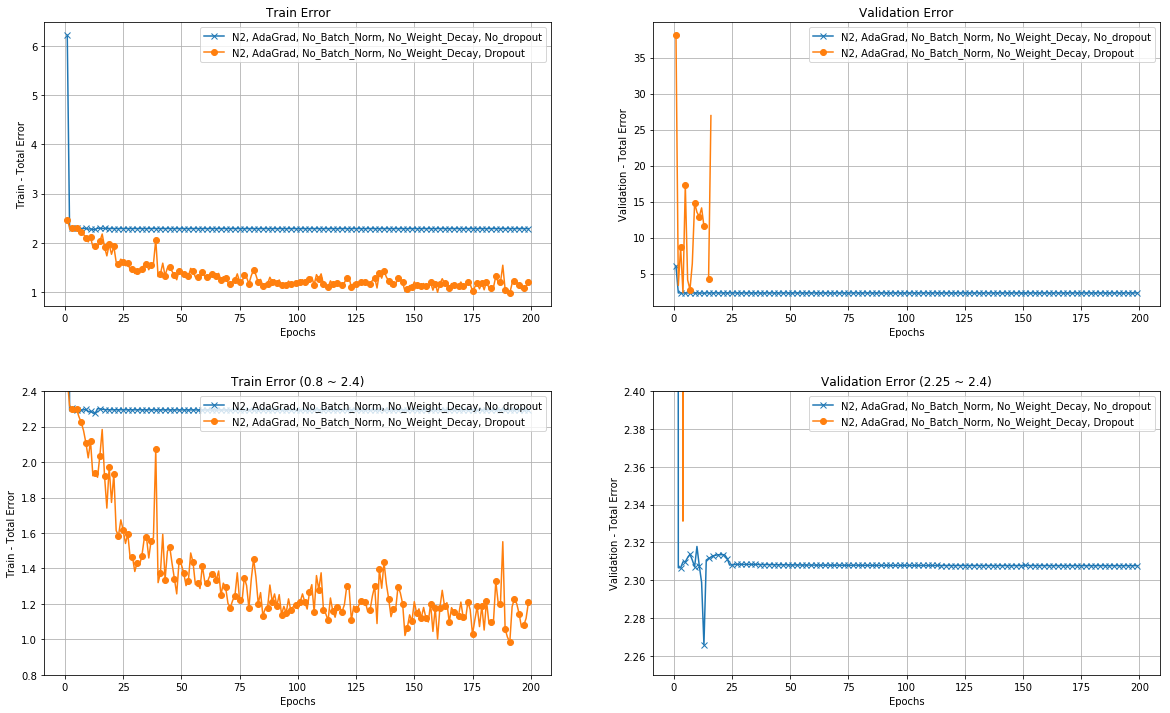

In [10]:
f, axarr = plt.subplots(2, 2, figsize=(20, 12))
for key in markers.keys():
    axarr[0, 0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0, 0].set_ylabel('Train - Total Error')
axarr[0, 0].set_xlabel('Epochs')
axarr[0, 0].grid(True)
axarr[0, 0].set_title('Train Error')
axarr[0, 0].legend(loc='upper right')

for key in markers.keys():
    axarr[0, 1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0, 1].set_ylabel('Validation - Total Error')
axarr[0, 1].set_xlabel('Epochs')
axarr[0, 1].grid(True)
axarr[0, 1].set_title('Validation Error')
axarr[0, 1].legend(loc='upper right')

for key in markers.keys():
    axarr[1, 0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1, 0].set_ylabel('Train - Total Error')
axarr[1, 0].set_xlabel('Epochs')
axarr[1, 0].grid(True)
axarr[1, 0].set_ylim(0.8, 2.4)
axarr[1, 0].set_title('Train Error (0.8 ~ 2.4)')
axarr[1, 0].legend(loc='upper right')

for key in markers.keys():
    axarr[1, 1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1, 1].set_ylabel('Validation - Total Error')
axarr[1, 1].set_xlabel('Epochs')
axarr[1, 1].grid(True)
axarr[1, 1].set_ylim(2.25, 2.4)
axarr[1, 1].set_title('Validation Error (2.25 ~ 2.4)')
axarr[1, 1].legend(loc='upper right')

f.subplots_adjust(hspace=0.3)

plt.show()

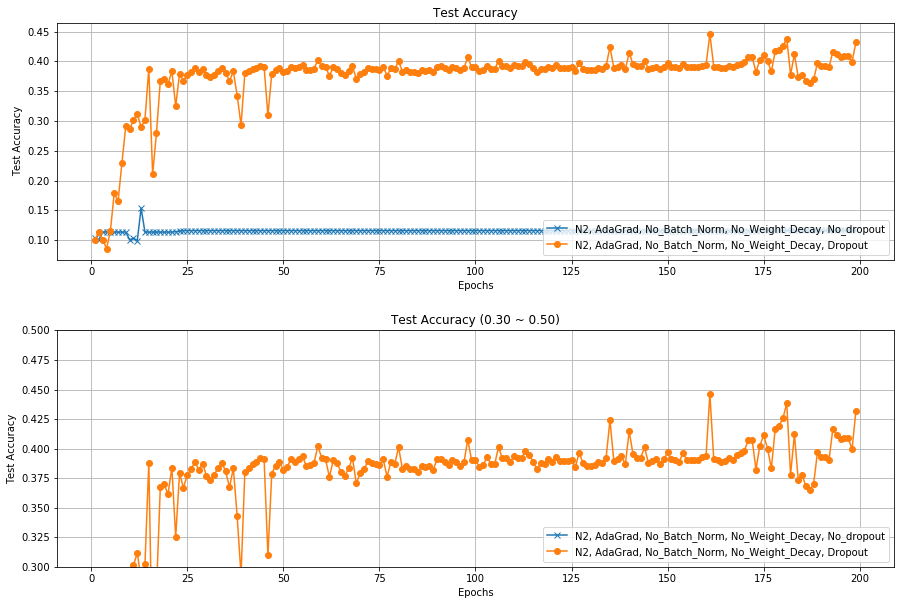

In [11]:
f, axarr = plt.subplots(2, 1, figsize=(15,10))
for key in markers.keys():
    axarr[0].plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=1, label=key)
axarr[0].set_ylabel('Test Accuracy')
axarr[0].set_xlabel('Epochs')
axarr[0].grid(True)
axarr[0].set_title('Test Accuracy')
axarr[0].legend(loc='lower right')

for key in markers.keys():
    axarr[1].plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=1, label=key)
axarr[1].set_ylabel('Test Accuracy')
axarr[1].set_xlabel('Epochs')
axarr[1].grid(True)
axarr[1].set_ylim(0.30, 0.50)
axarr[1].set_title('Test Accuracy (0.30 ~ 0.50)')
axarr[1].legend(loc='lower right')

f.subplots_adjust(hspace=0.3)
plt.show()

In [12]:
for key in markers.keys():
    print("{0:26s} - Epoch:{1:3d}, Max Test Accuracy: {2:7.5f}".format(key, max_test_accuracy_epoch[key], max_test_accuracy_value[key]))

N2, AdaGrad, No_Batch_Norm, No_Weight_Decay, No_dropout - Epoch: 13, Max Test Accuracy: 0.15370
N2, AdaGrad, No_Batch_Norm, No_Weight_Decay, Dropout - Epoch:161, Max Test Accuracy: 0.44620
